In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
import os

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
df = pd.read_csv("OnlineRetail.csv")
list(df.columns)


['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [6]:
df.shape

(541909, 8)

In [7]:
df.dtypes


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [8]:
df.isnull()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
541904,False,False,False,False,False,False,False,False
541905,False,False,False,False,False,False,False,False
541906,False,False,False,False,False,False,False,False
541907,False,False,False,False,False,False,False,False


In [9]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df[df.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32,1.66,NaN,United Kingdom


In [11]:
135080/df.shape[0] # 0.2492    df.shape[0] = len(df)

0.249266943342886

In [12]:
df['CustomerID'].nunique()

4372

In [13]:
len(df[df.Quantity<0])

10624

In [14]:
dfnew = df[(df.Quantity>0) & (df.CustomerID.isnull() == False)]

In [15]:
dfnew.shape

(397924, 8)

In [16]:
dfnew['amt'] = dfnew['Quantity'] * dfnew['UnitPrice']

dfnew['InvoiceDate'] = pd.to_datetime(dfnew['InvoiceDate']).dt.date


# Customer lifetime value analysis

In [17]:
from lifetimes.plotting import *
from lifetimes.utils import *

In [18]:
modeldata = summary_data_from_transaction_data(dfnew, 'CustomerID', 'InvoiceDate', monetary_value_col='amt', observation_period_end='2011-12-9')
modeldata.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


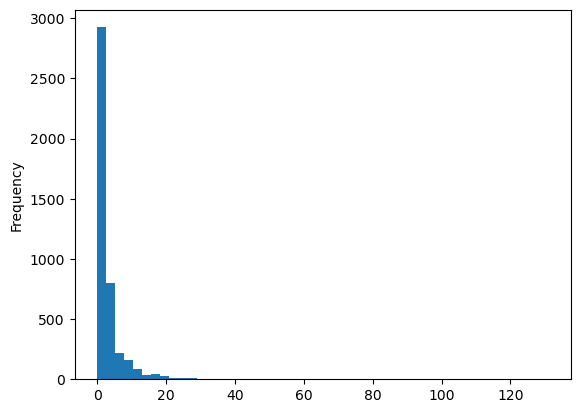

In [19]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

In [20]:
dfnew[dfnew.CustomerID == 12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amt
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,77183.6


In [21]:
#betageofitter to fit customer transaction data 

from lifetimes import BetaGeoFitter
# similar API to scikit-learn and lifelines.

In [22]:
bgf = BetaGeoFitter(penalizer_coef=0.0)

In [23]:
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)


<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

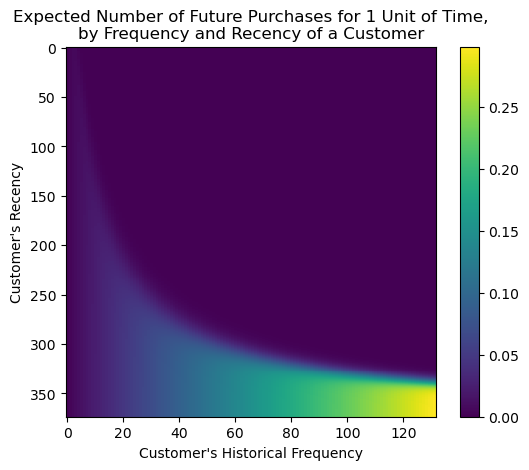

In [24]:
# create frequency recency matrix
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

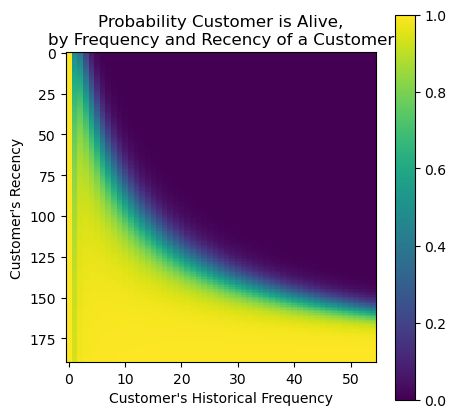

In [84]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(5,5))
plot_probability_alive_matrix(bgf)

In [26]:
t = 1
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


In [27]:
modeldata.sort_values(by='predicted_purchases').head(895)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
18074.0,0.0,0.0,373.0,0.00,0.001870
16048.0,0.0,0.0,373.0,0.00,0.001870
16274.0,0.0,0.0,373.0,0.00,0.001870
14237.0,0.0,0.0,373.0,0.00,0.001870
14142.0,0.0,0.0,373.0,0.00,0.001870
...,...,...,...,...,...
17194.0,1.0,87.0,360.0,10.00,0.004245
14544.0,1.0,337.0,361.0,902.53,0.004246
17371.0,1.0,344.0,361.0,326.26,0.004246


            frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
CustomerID                                                                        
12346.0               0.0          0.0  141.0                0.0             184.0
12347.0               2.0        121.0  183.0                4.0             184.0
12348.0               2.0        110.0  174.0                1.0             184.0
12350.0               0.0          0.0  126.0                0.0             184.0
12352.0               3.0         34.0  112.0                3.0             184.0


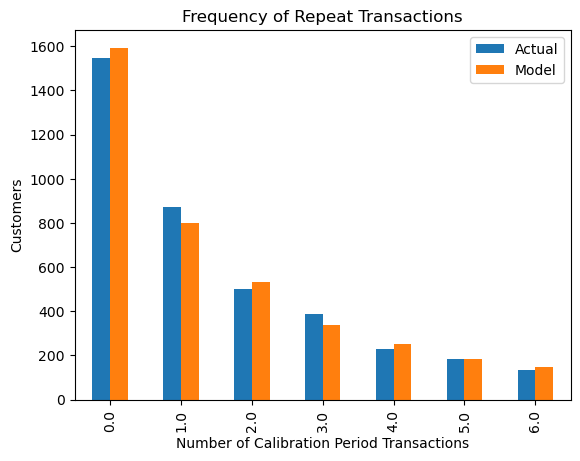

In [28]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)


summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

C:\Users\Harip\anaconda3\Anaconda\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

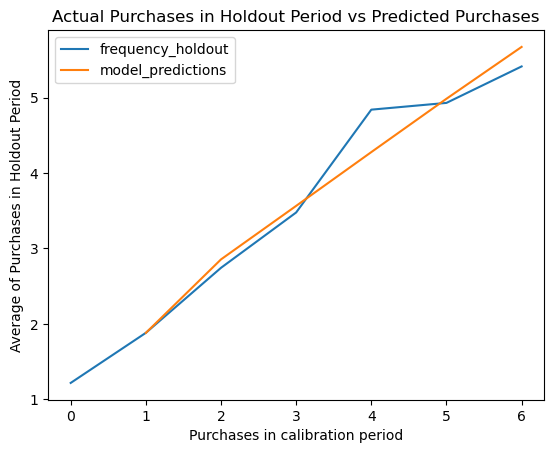

In [29]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


In [30]:
t = 10
individual = modeldata.loc[12380]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15861476348707357

With the CLV model we have created,
we can specifically estimate a customer's historical probability of 
being alive. 

In [31]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

TypeError: 'value' must be an instance of str or bytes, not a pandas._libs.tslibs.timestamps.Timestamp

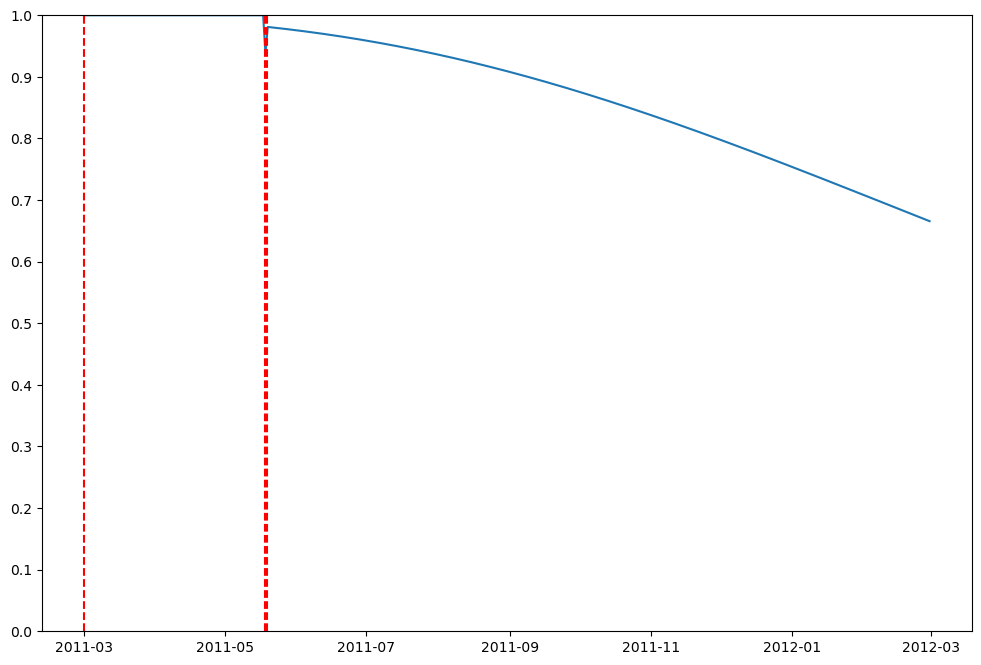

In [32]:
fig = plt.figure(figsize=(12,8))
id = 14620  # id = 18074  id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

# We are only estimating the customers who had at least one repeat purchase with us

In [33]:
returning_customers_summary = modeldata[modeldata['frequency']>0]


In [34]:
print(returning_customers_summary.head())

print(len(returning_customers_summary))
modeldata.shape


            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015656
12348.0           3.0    283.0  358.0      301.480000             0.008956
12352.0           6.0    260.0  296.0      368.256667             0.018697
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008340
2790


(4339, 5)

In [36]:
#gammafitter 

from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

print(ggf)

print(ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10))


<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>
CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


to use xgb

In [39]:
import datetime
dfnew.InvoiceDate.max()
dfnew.InvoiceDate.min()
A = dfnew[dfnew.InvoiceDate>datetime.date(2011, 11, 9)]
A.shape
Z = pd.DataFrame(A.CustomerID.value_counts()).reset_index()
list(Z.columns)
Z.columns = ['CustomerID','buytime']
Z = Z.sort_values(['buytime'], ascending = False)
Z.head(20)

len(Z)
len(set(dfnew.CustomerID))

allcus = pd.DataFrame(set(dfnew.CustomerID), columns = ['CustomerID'])

allcus = pd.merge(allcus, Z, on=['CustomerID'], how='left').sort_values(['buytime'], ascending = False)
allcus = allcus.fillna(0)

allcus['buytime'] = allcus['buytime']/allcus['buytime'].max()

allcus['v1'] = allcus['buytime']*0.78 + np.random.normal(0, 0.11, len(allcus))

allcus['v2'] = allcus['buytime']*allcus['buytime']*(-0.195) + 0.11*allcus['buytime']

allcus.corr()


allcus['v1'] = (allcus['v1'] - allcus['v1'].min())/(allcus['v1'].max() - allcus['v1'].min())

allcus['v2'] = (allcus['v2'] - allcus['v2'].min())/(allcus['v2'].max() - allcus['v2'].min())

allcus['score'] = round(allcus['v2']*100000)
allcus.score.max()


allcus['discount'] = round(allcus['v1']*12.6)

allcus['r'] = np.random.randint(100,size=len(allcus))

def def2(D):
    if D['r']<13:
        x = 0
    else:
        x = D['discount']
    
    return x

allcus['discount'] = allcus.apply(def2, axis = 1)

v = ['CustomerID', 'score', 'discount']
allcus = allcus[v]

allcus = allcus.sort_values(['score'])

allcus.score.std()
allcus.corr()

allcus.to_csv('oth.csv', index = False)

In [40]:
list(dfnew.columns)
dfnew_train = dfnew[dfnew.InvoiceDate < datetime.date(2011, 11, 9)]
dfnew_test = dfnew[dfnew.InvoiceDate >= datetime.date(2011, 11, 9)]

maxdate = dfnew_train.InvoiceDate.max()
mindate = dfnew_train.InvoiceDate.min()

In [41]:
dfnew_train['duration'] =  (maxdate - dfnew_train.InvoiceDate)/np.timedelta64(1, 'D')

In [42]:
# get time duration between the last transaction to now
dfsum1 = dfnew_train.groupby(['CustomerID'])['duration'].min().reset_index()
dfsum1.head()

dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)


In [43]:
# get time duration between the first transaction to now
dfsum2 = dfnew_train.groupby(['CustomerID'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)


In [44]:
# get transaction frequency (whole history)
dfnew_train['freq'] =1 
dfsum3 = dfnew_train.groupby(['CustomerID'])['freq'].sum().reset_index()


In [45]:
# get transaction frequency (recent 3 months history)
dfnew_train['freq_3m'] =1 
dfsum4 = dfnew_train[dfnew_train.duration<91].groupby(['CustomerID'])['freq_3m'].sum().reset_index()

In [46]:
dfsum = pd.merge(dfsum1, dfsum2, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['CustomerID'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['CustomerID'], how='outer')

In [47]:
#get other data source
other_data = pd.read_csv('oth.csv')
list(other_data.columns)
dfsum = pd.merge(dfsum, other_data, on=['CustomerID'], how='left')


In [48]:
# get target 
dfnew_test['target'] = 1
dfsum_target = dfnew_test.groupby(['CustomerID'])['target'].sum().reset_index()


In [49]:
dfsum = pd.merge(dfsum, dfsum_target, on=['CustomerID'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)


In [50]:
# check all features in the modeling data
list(dfsum.columns)
dfsum.head(10)

,CustomerID,latetime,earlytime,freq,freq_3m,score,discount,target
1216,14096.0,8.0,70.0,2688,2688.0,0.0,13.0,2423.0
300,12748.0,0.0,342.0,2945,1070.0,70118.0,9.0,1651.0
3766,17841.0,0.0,342.0,6309,2548.0,81346.0,8.0,1538.0
1770,14911.0,1.0,342.0,4566,2066.0,95982.0,9.0,1111.0
2896,16549.0,0.0,303.0,511,368.0,100000.0,3.0,470.0
1572,14606.0,1.0,342.0,2364,531.0,97479.0,6.0,336.0
1463,14456.0,9.0,111.0,645,404.0,97218.0,5.0,325.0
2772,16360.0,7.0,57.0,372,372.0,96335.0,6.0,290.0
2052,15311.0,4.0,342.0,2104,535.0,95428.0,5.0,275.0
4065,18283.0,12.0,306.0,487,87.0,95766.0,5.0,269.0


XGB Model

In [51]:
import xgboost
from sklearn.model_selection import train_test_split

In [52]:
xgb_model = xgboost.XGBRegressor(n_estimators=2200, objective='reg:linear', max_depth = 5)

In [53]:
predictors = ['latetime','earlytime', 'freq','freq_3m', 'score','discount']
X = dfsum[predictors]
y = dfsum.target

In [54]:
x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)

In [55]:
xgb_model.fit(x_trains, y_train)

C:\Users\Harip\anaconda3\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [15:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [56]:
preds = xgb_model.predict(x_valids)
errs= np.abs(preds - y_valid)**2
mse = np.sqrt(errs.mean())

In [57]:
from xgboost import plot_importance
from matplotlib import pyplot

In [58]:
# for XGBRegressor, we use the following ways
xgb_model.get_booster().get_score(importance_type="gain")
xgb_model.get_booster().get_score(importance_type="weight")


{'latetime': 7407.0,
 'earlytime': 6201.0,
 'freq': 6838.0,
 'freq_3m': 3311.0,
 'score': 3277.0,
 'discount': 2306.0}

'''
importance_type:
    
‘weight’ - the number of times a feature is used to split the data across all trees.
‘gain’ - the average gain across all splits the feature is used in.
‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)
‘total_gain’ - the total gain across all splits the feature is used in.
‘total_cover’ - the total coverage across all splits the feature is used in.

'''

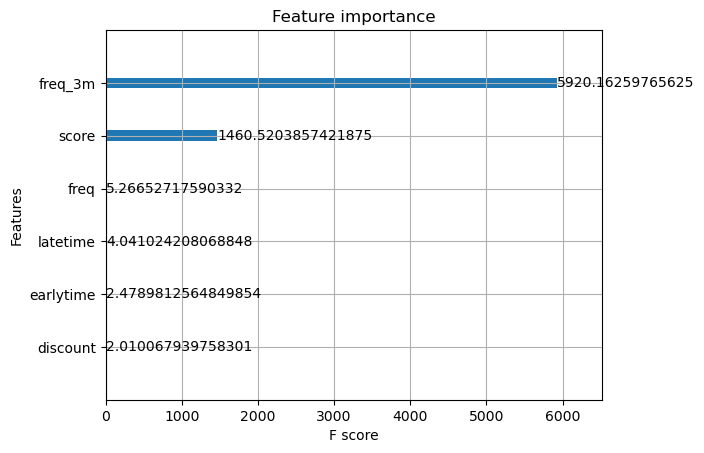

In [59]:
# plot feature importance
plot_importance(xgb_model, importance_type='gain')
pyplot.show()

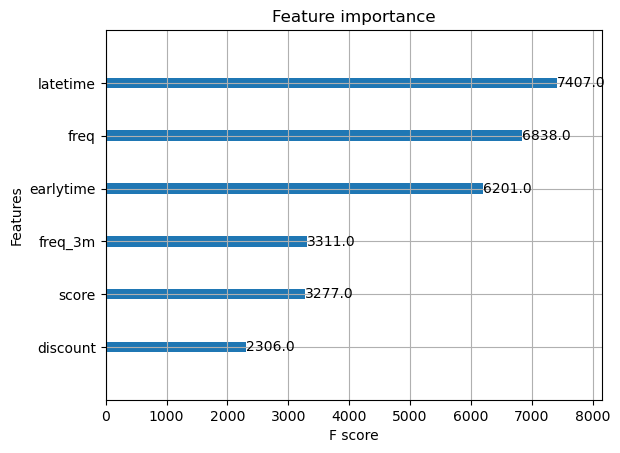

In [60]:
plot_importance(xgb_model, importance_type='weight') # default option is 'weight'
pyplot.show()

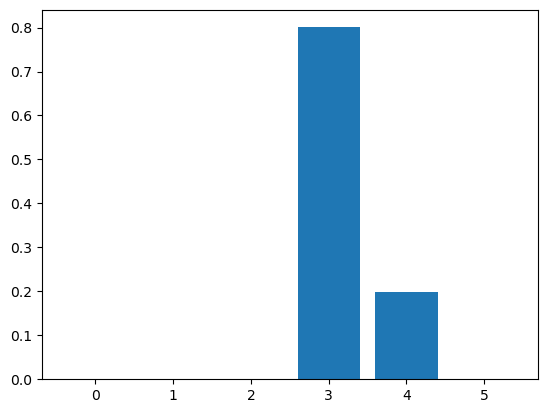

In [61]:
# we can also use feature_importances_, but it is the same as importance_type='gain'
imp = xgb_model.feature_importances_
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

In [62]:
#  we can list importance by dict, by 'gain'
sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]
for index in sorted_idx:
    print([x_trains.columns[index], xgb_model.feature_importances_[index]]) 


['freq_3m', 0.8006192]
['score', 0.19751495]
['freq', 0.00071222417]
['latetime', 0.000546492]
['earlytime', 0.00033524755]
['discount', 0.0002718336]


In [63]:
important_var = [(x_trains.columns[index], xgb_model.feature_importances_[index]) for index in sorted_idx]

In [64]:
# check correlation of features with target
dfsum.corr()

,CustomerID,latetime,earlytime,freq,freq_3m,score,discount,target
CustomerID,1.000000,0.010700,0.008295,-0.000879,0.000297,0.017148,0.054338,-0.001660
latetime,0.010700,1.000000,0.320846,-0.213880,-0.274409,-0.106303,-0.035017,-0.109399
earlytime,0.008295,0.320846,1.000000,0.214979,0.024627,0.097698,0.032404,0.071634
freq,-0.000879,-0.213880,0.214979,1.000000,0.878293,0.065750,0.103934,0.731558
freq_3m,0.000297,-0.274409,0.024627,0.878293,1.000000,-0.180902,0.112904,0.825482
score,0.017148,-0.106303,0.097698,0.065750,-0.180902,1.000000,-0.023162,-0.194449
discount,0.054338,-0.035017,0.032404,0.103934,0.112904,-0.023162,1.000000,0.117299
target,-0.001660,-0.109399,0.071634,0.731558,0.825482,-0.194449,0.117299,1.000000


In [65]:
##light gbm model

In [66]:
import lightgbm as lgb  

In [67]:
lgbparams = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',    
    'max_depth': 6, 
    'learning_rate': 0.02
}


In [68]:
predictors = ['latetime','earlytime', 'freq','freq_3m', 'score','discount']

In [69]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, random_state=12)

In [70]:
x_trains, x_valids, y_train, y_valid = train_test_split(X1, y1, test_size=0.1, random_state=12)
x_train = x_trains[predictors]
x_valid = x_valids[predictors]


In [71]:
d_train = lgb.Dataset(x_train, label=y_train)
d_valid = lgb.Dataset(x_valid, label=y_valid)

In [72]:
# for monitoring the performance
watchlist = [d_valid]
n_estimators = 2200 # this para will be set in train()


In [81]:
model = lgb.train(lgbparams, d_train, n_estimators, watchlist, verbose=1)


TypeError: train() got an unexpected keyword argument 'verbose'

In [76]:

preds = model.predict(X2)
errs= np.abs(preds - y2)**2
mse = np.sqrt(errs.mean())

In [77]:
print('Feature importances:', list(model.feature_importance()))
important_var = list(zip(predictors,list(model.feature_importance())))
important_var.sort(key = lambda t: t[1])

Feature importances: [2520, 2943, 7487, 4367, 4196, 2655]


In [78]:
print (important_var)
len(important_var)


[('latetime', 2520), ('discount', 2655), ('earlytime', 2943), ('score', 4196), ('freq_3m', 4367), ('freq', 7487)]


6

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), x_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

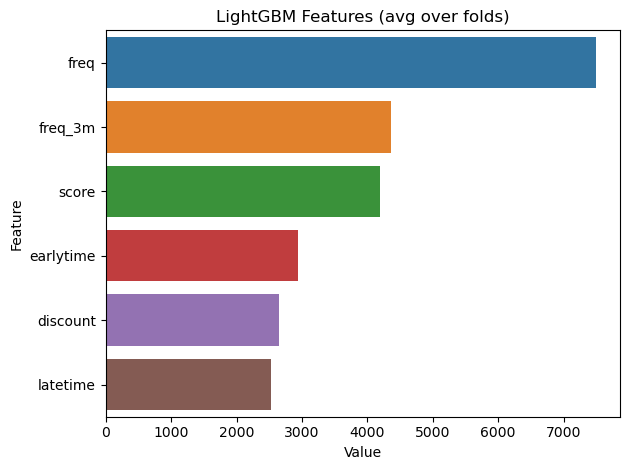

In [80]:
# other way seaborn for importance levels
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
